# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Importing Libraries

In [23]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import pickle
%matplotlib inline

# reading the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Exploring Data

In [24]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [25]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [26]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [27]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [28]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [29]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# Data Cleaning Functions

#### Cleaning Portfolio by
- changing the duration from day to hour
- Isolating Channel Column Attributes
- applying one hot encoding to offer_type column
- dropping the channels and offer_type column
- combine the portfolio and offer_type dataframe to form a cleaned dataframe

In [30]:
def clean_portfolio():
    '''
    This function cleans Portfolio Dataframe
    
    INPUT:
    None
    
    OUTPUT:
    portfolio - Cleaned Portfolio Dataframe
    
    '''
    # changing the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # Isolating Channel Column Attributes
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # applying one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # dropping the channels and offer_type column
    #cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    return cleaned_portfolio

#### Cleaning Profile by 
- Encoding missing value of age as 118
- dropping all missing values
- Calculating number of membership days
- Transforming became_member column to Proper Date Format

In [31]:
def clean_profile():
    '''
    This function cleans Profile Dataframe
    
    INPUT:
    None
    
    OUTPUT:
    profile - The Cleaned Profile Dataframe
    
    '''
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    #Transforming became_member column to Proper Date Format
    profile['date'] = profile.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    profile['year'] = profile.became_member_on.apply(lambda x: int(str(x)[:4]))
    profile['month'] = profile.became_member_on.apply(lambda x: int(str(x)[4:6]))
    profile['day'] = profile.became_member_on.apply(lambda x: int(str(x)[6:]))
    
    return profile

#### Cleaning Transcript by
- extracting the rows that are related to offer received, offer viewed and offer completed
- extracting offer_id from value Column

In [32]:
def clean_transcript():
    '''
    This Function cleans Transcript Dataframe
    
    INPUT:
    None
    
    OUTPUT:
    offer - Cleaned learned offer Dataframe
    
    '''
    # extract the rows that are related to offer received, offer viewed and offer completed
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extracting offer_id from value Column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

## Cleaning all data

In [33]:
portfolio = clean_portfolio()
profile = clean_profile()
offers = clean_transcript()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


### Exloring Cleaned Data

In [34]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,web,email,mobile,social,bogo,discount,informational
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


In [35]:
profile.head()

,gender,age,id,became_member_on,income,memberdays,date,year,month,day
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1021,2017-07-15,2017,7,15
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1088,2017-05-09,2017,5,9
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0,736,2018-04-26,2018,4,26
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,812,2018-02-09,2018,2,9
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,902,2017-11-11,2017,11,11


# Transforming Data
### Following steps were performed when Transforming Data
- renaming 'id' column of Profile as 'Person'
- merging offers and profile_renamed as 'combined'
- Filterig 'Type' and 'Value' columns of 'combined' Dataframe
- renaming 'id' column of portfolio as 'offer_id'
- combining all three .json files

In [36]:
#renaming 'id' column of Profile as 'Person'
profile_renamed = profile.rename(columns={'id':'person'})

#merging offers and profile_renamed as 'combined'
combined = pd.merge(offers, profile_renamed, on='person')

# Filterig 'Type' and 'Value' columns of 'combined' Dataframe
combined['type'] = combined['value'].apply(lambda x: list(x.keys())[0])
combined['value'] = combined['value'].apply(lambda x: list(x.values())[0])

#renaming 'id' column of portfolio as 'offer_id'
portfolio_renamed = portfolio.rename(columns={'id':'offer_id'})

# combining all three .json files
all_data = pd.merge(combined, portfolio_renamed, on='offer_id')
#all_data.head()

# Vizualizing Data

Text(0.5, 0, 'Income')

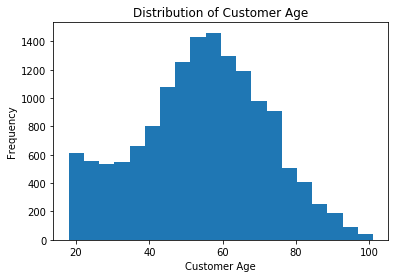

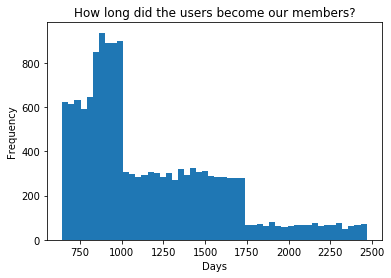

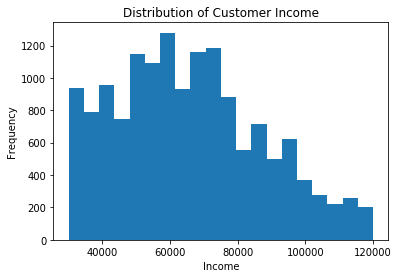

In [37]:
user_age = profile['age'].plot(kind='hist', bins=20, title='Distribution of Customer Age')
user_age.set_xlabel("Customer Age")

plt.figure()
memberdays = profile['memberdays'].plot(kind='hist', bins=50, title='How long did the users become our members?')
memberdays.set_xlabel("Days")

plt.figure()
user_income = profile['income'].plot(kind='hist', bins=20, title='Distribution of Customer Income')
user_income.set_xlabel("Income")


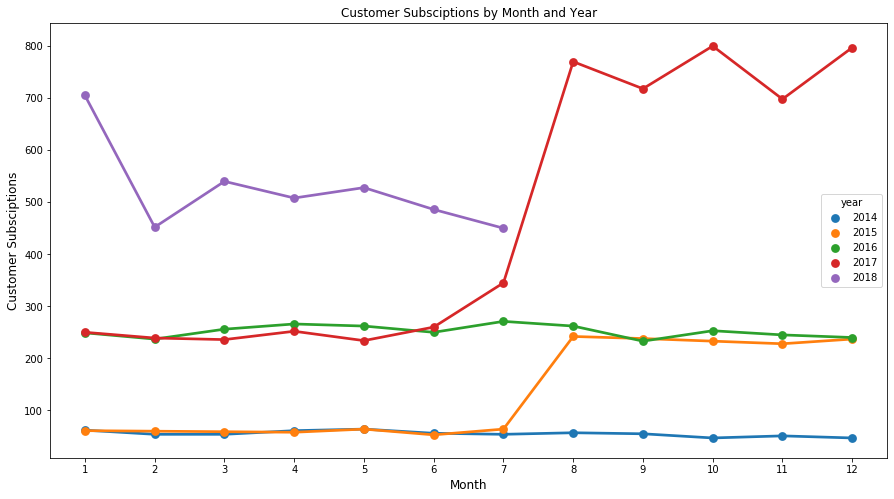

In [38]:
membership_subs = profile[profile['year'] >= 2014].groupby(['year','month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="month", y="id", hue="year", data = membership_subs)
plt.ylabel('Customer Subsciptions', fontsize = 12)
plt.xlabel('Month', fontsize = 12)
plt.title('Customer Subsciptions by Month and Year');

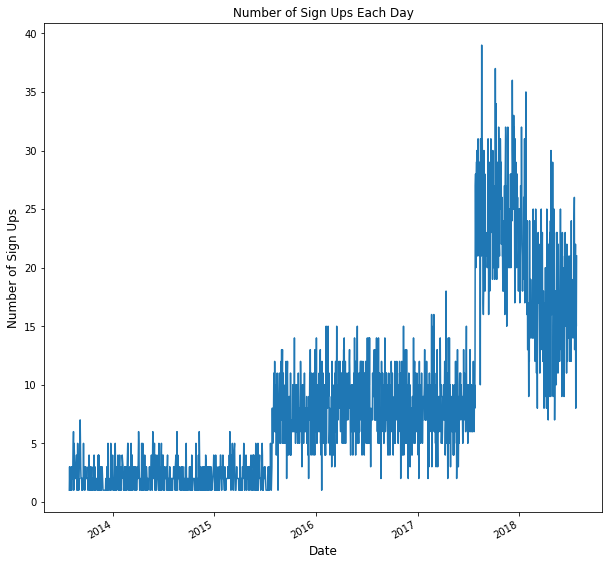

In [39]:
profile.date.value_counts().plot(kind = 'line', figsize = (10,10))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Number of Sign Ups', fontsize = 12)
plt.title('Number of Sign Ups Each Day');

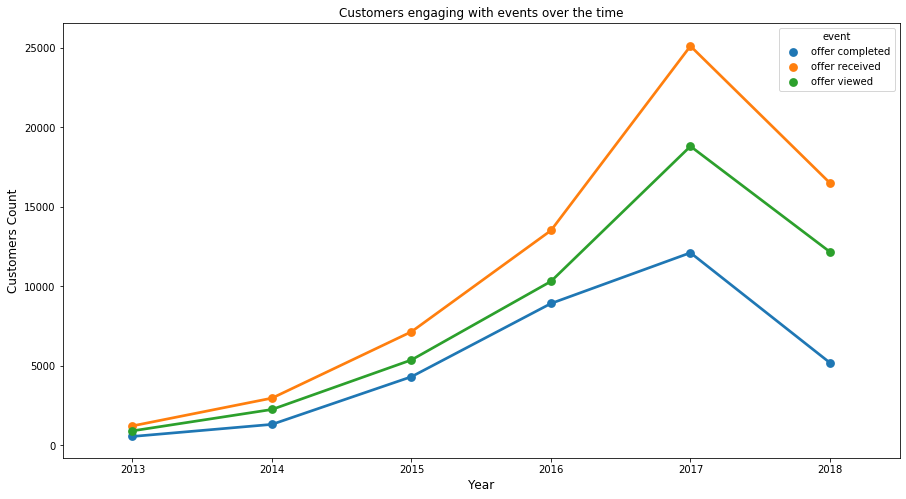

In [40]:
combined_data = combined[combined['time'] <= 1000].groupby(['event','year'], as_index=False).agg({'person':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="year", y="person", hue="event", data = combined_data)
plt.ylabel('Customers Count', fontsize = 12)
plt.xlabel('Year', fontsize = 12)
plt.title('Customers engaging with events over the time');

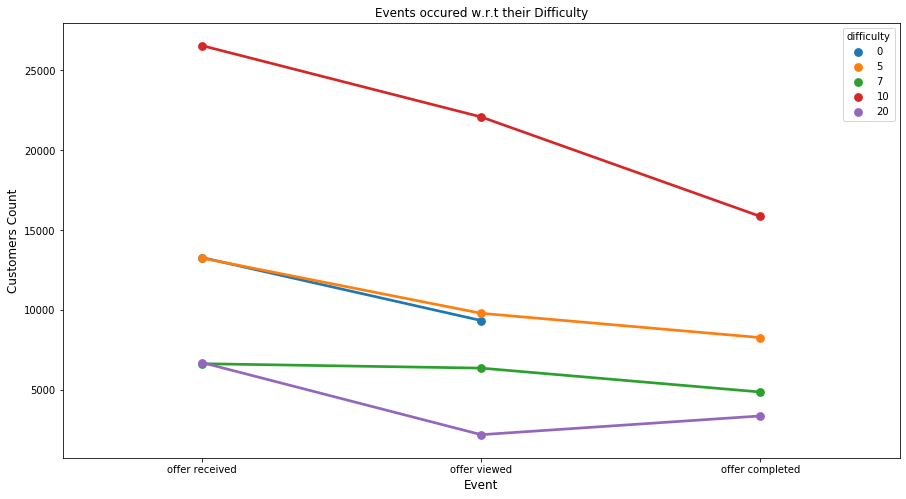

In [41]:
difficulty = all_data[all_data['age'] <= 100].groupby(['difficulty','event'], as_index=False).agg({'person':'count'})
plt.figure(figsize=(15,8))
sns.pointplot(x="event", y="person", hue="difficulty", data = difficulty)
plt.ylabel('Customers Count', fontsize = 12)
plt.xlabel('Event', fontsize = 12)
plt.title('Events occured w.r.t their Difficulty');

In [42]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [43]:
full_df = create_user_item_matrix(offers, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [44]:
train_size = int(offers.shape[0]*0.7)
test_size = offers.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [45]:
train_offer = offers[:train_size]
test_offer = offers[train_size:]
train_df = create_user_item_matrix(train_offer, 'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [46]:
test_df = create_user_item_matrix(test_offer, 'test_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128

In [60]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [62]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=150)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.314692
2 		 0.267966
3 		 0.267615
4 		 0.267254
5 		 0.266889
6 		 0.266520
7 		 0.266146
8 		 0.265767
9 		 0.265383
10 		 0.264993
11 		 0.264597
12 		 0.264195
13 		 0.263786
14 		 0.263370
15 		 0.262945
16 		 0.262512
17 		 0.262071
18 		 0.261619
19 		 0.261157
20 		 0.260684
21 		 0.260200
22 		 0.259702
23 		 0.259192
24 		 0.258666
25 		 0.258126
26 		 0.257568
27 		 0.256994
28 		 0.256400
29 		 0.255787
30 		 0.255152
31 		 0.254494
32 		 0.253812
33 		 0.253105
34 		 0.252370
35 		 0.251605
36 		 0.250810
37 		 0.249982
38 		 0.249119
39 		 0.248219
40 		 0.247281
41 		 0.246300
42 		 0.245276
43 		 0.244207
44 		 0.243088
45 		 0.241919
46 		 0.240696
47 		 0.239416
48 		 0.238078
49 		 0.236679
50 		 0.235215
51 		 0.233685
52 		 0.232085
53 		 0.230414
54 		 0.228668
55 		 0.226846
56 		 0.224946
57 		 0.222965
58 		 0.220902
59 		 0.218756
60 		 0.216526
61 		 0.214210
62 		 0.211808
63 		 0.209321
64 		 0

In [63]:
user_mat_20, offer_mat_20 = FunkSVD(train_data_np, latent_features=20, learning_rate=0.005, iters=150)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.329035
2 		 0.268947
3 		 0.268644
4 		 0.268320
5 		 0.267989
6 		 0.267652
7 		 0.267307
8 		 0.266954
9 		 0.266592
10 		 0.266221
11 		 0.265839
12 		 0.265448
13 		 0.265044
14 		 0.264628
15 		 0.264199
16 		 0.263756
17 		 0.263297
18 		 0.262821
19 		 0.262328
20 		 0.261816
21 		 0.261284
22 		 0.260730
23 		 0.260152
24 		 0.259550
25 		 0.258921
26 		 0.258263
27 		 0.257574
28 		 0.256853
29 		 0.256098
30 		 0.255305
31 		 0.254472
32 		 0.253598
33 		 0.252679
34 		 0.251712
35 		 0.250696
36 		 0.249626
37 		 0.248501
38 		 0.247316
39 		 0.246070
40 		 0.244758
41 		 0.243378
42 		 0.241927
43 		 0.240402
44 		 0.238800
45 		 0.237118
46 		 0.235353
47 		 0.233504
48 		 0.231567
49 		 0.229542
50 		 0.227426
51 		 0.225219
52 		 0.222920
53 		 0.220529
54 		 0.218045
55 		 0.215470
56 		 0.212804
57 		 0.210051
58 		 0.207211
59 		 0.204289
60 		 0.201287
61 		 0.198210
62 		 0.195061
63 		 0.191848
64 		 0

In [70]:
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=30, learning_rate=0.005, iters=150)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.377391
2 		 0.272950
3 		 0.272645
4 		 0.272323
5 		 0.271989
6 		 0.271643
7 		 0.271285
8 		 0.270912
9 		 0.270524
10 		 0.270120
11 		 0.269699
12 		 0.269259
13 		 0.268799
14 		 0.268317
15 		 0.267813
16 		 0.267283
17 		 0.266727
18 		 0.266142
19 		 0.265526
20 		 0.264878
21 		 0.264194
22 		 0.263472
23 		 0.262710
24 		 0.261905
25 		 0.261054
26 		 0.260154
27 		 0.259201
28 		 0.258193
29 		 0.257125
30 		 0.255995
31 		 0.254798
32 		 0.253531
33 		 0.252190
34 		 0.250770
35 		 0.249268
36 		 0.247681
37 		 0.246003
38 		 0.244231
39 		 0.242362
40 		 0.240392
41 		 0.238317
42 		 0.236136
43 		 0.233844
44 		 0.231441
45 		 0.228924
46 		 0.226292
47 		 0.223546
48 		 0.220684
49 		 0.217709
50 		 0.214621
51 		 0.211424
52 		 0.208121
53 		 0.204716
54 		 0.201214
55 		 0.197621
56 		 0.193944
57 		 0.190189
58 		 0.186366
59 		 0.182481
60 		 0.178545
61 		 0.174567
62 		 0.170556
63 		 0.166521
64 		 0

In [71]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(train_df.index)
        offer_ids_series = np.array(train_df.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        #print("I'm sorry, but a prediction cannot be made for this user-offer pair.  It looks like one of these items does not exist in our current database.")
    
        return None

In [72]:
def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(test_df))
    
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = test_df.loc[user_id, offer_id] - predict_reaction(user_mat, offer_mat, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [67]:
# Evaluation for latent features of 15
validation(test_df, user_mat, offer_mat)

0.30729319937877664


In [68]:
# Evaluation for latent features of 10
validation(test_df, user_mat_20, offer_mat_20)

0.31667934481115223


In [73]:
# Evaluation for latent features of 5
validation(test_df, user_mat_5, offer_mat_5)

0.32515185379138684


In [74]:
def recommend_offer(user_id, user_mat, offer_mat):
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
    if pred_val == None:
        print("Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.")
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))

In [75]:
# recommend offer for a particular user
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.57
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.19
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  -0.12
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  -0.13
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  -0.23
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  -0.32
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  -0.85
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  -0.85


In [80]:
# recommend offer for a particular user
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat_5, offer_mat_5)

recommend offer for user  0610b486422d4921ae7d2bf64640c50b
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.98
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.95
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.4
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.37
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.0
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  -0.1
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  -0.12
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  -0.45


In [77]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94


,offer_id,gain
7,fafdcd668e3743c1bb461111dcafc2a4,596220.84
1,2298d6c36e964ae4a3e7e9706d1fb8c2,538027.98
6,f19421c1d4aa40978ebb69ca19b0e20d,480555.03
3,4d5c57ea9a6940dd891ad53e9dbe8da0,441918.93
5,ae264e3637204a6fb9bb56bc8210ddfd,423683.27
2,2906b810c7d4411798c6938adc9daaa5,305568.42
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,304361.77
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,218905.94


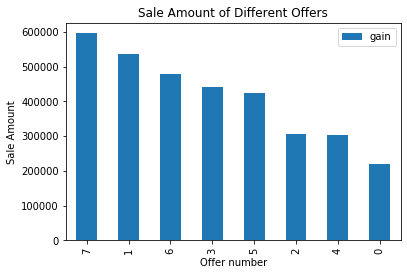

In [78]:
best_sale_offer(full_df)

Because this user wasn't in our database, we are giving back the top best sale offer recommendations for all users.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


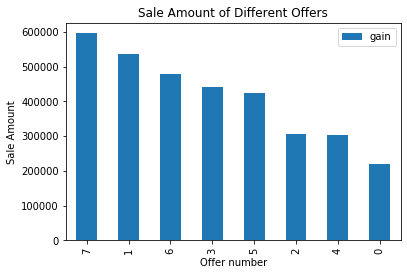

In [79]:
# we recommend top best sale offer to a new user
recommend_offer('new_user', user_mat, offer_mat)